# Using Jax JVP

The `jvp` (jacobian-vector-product) method in the jax library is super powerful for computing derivatives.  I'll use the following vector function to illustrate.

$$
\begin{bmatrix}
y_1\\
y_2
\end{bmatrix} = \begin{bmatrix}
a \sin\left(\omega t\right)\\
a \cos\left(\omega t\right)\\
\end{bmatrix} 
$$

Now, for computational work, I'd like to assume that $t$ is a numpy array, so that $y_1$ and $y_2$ are actually timeseries.  Jax's `jvp` method is pretty cool in that it will allow me to numerically compute all of the following:

$$
\frac{\partial y_1} {\partial a} = \sin\left(\omega t\right)
$$

$$
\frac{\partial y_2} {\partial a} = \cos\left(\omega t\right)
$$

$$
\frac{\partial y_1} {\partial w} = a t\cos\left(\omega t\right)
$$

$$
\frac{\partial y_2} {\partial w} = - a t\sin\left(\omega t\right)
$$

$$
\frac{\partial y_1} {\partial t} = a \omega \cos\left(\omega t\right)
$$

$$
\frac{\partial y_2} {\partial t} = - a \omega \sin\left(\omega t\right)
$$

and each of the partials will be the corresponding time-series.

Let's write some code to actually do this.



In [12]:
# Import the stuff you'll need from jax
import jax
from jax import jvp, jit

# Jax has it's own version of numpy that enables autodiff
import jax.numpy as jnp

# Set up matplotlib for plotting
import pylab as pl
%matplotlib inline

In [13]:
# Now define my function.  I will apply the jax jit decorator to improve performance.

def func(t, params):
    # I will fold the a and w parameters into a parameter array separate from time
    a, w = params
    
    # Define the elements in the return vector
    y1 = a * jnp.sin(w * t)
    y2 = a * jnp.cos(w * t)
    
    # Return a jax array of the vector
    return jnp.array([y1, y2])

In [14]:
# Define some values for the variables so that I can do numerical computations

# Make an array of times
t = jnp.linspace(0, 1, 300)

# Define the amplitude
a = 1

# Define the angular frequency
w = 2 * jnp.pi * 1

# Make the params array
params = jnp.array([a, w])

All right.  Now comes the tricky part.  The arguments to the jvp method are not that obvious so I'll try to annotate them here.

In [15]:
result = jax.jvp(
    func,                         # fun:       This is the function for which you want to compute partials 
    (t, params),                  # primals:   This is a tuple of arguments specifying the 
                                  #            point at which you want to compute the partials
    (
        jnp.ones_like(t),         # tangents:  This is a tuple of tangents to use when evaluating partials. (see explanation below)
        jnp.zeros_like(params)
    )             
)                                 # result:  The returned result will also be explained below

Now to explain the arguments.  Let's consider a super simple function just to illustrate the point, then we'll go back to our example function above.
Consider
$$z = g\left(x, y\right) = 3 x + 5 y.$$
And now lets say I'd like to know how much $z$ would change if I went from $\left(x, y\right) = \left(1, 1\right)$ to  $\left(x, y\right) = \left(1 + dx, 1\right).$

I could approximate this with
$$
g\left(1 + dx, 1\right) = dx \frac{\partial g\left(x, y\right)}{\partial x}\Bigr|_{x=1, y=1} + 0 \frac{\partial g\left(x, y\right)}{\partial y}\Bigr|_{x=1, y=1}.
$$
Similarly,
$$
g\left(1, 1 + dy\right) = 0 \frac{\partial g\left(x, y\right)}{\partial x}\Bigr|_{x=1, y=1} + dy \frac{\partial g\left(x, y\right)}{\partial y}\Bigr|_{x=1, y=1},
$$
and
$$
g\left(1 + dx, 1 + dy\right) = dx \frac{\partial g\left(x, y\right)}{\partial x}\Bigr|_{x=1, y=1} + dy \frac{\partial g\left(x, y\right)}{\partial y}\Bigr|_{x=1, y=1}.
$$


This can be rewritten in matrix notation as
$$
dg = \begin{bmatrix}
\frac{\partial g\left(x, y\right)}{\partial x} & \frac{\partial g\left(x, y\right)}{\partial y}\\
\end{bmatrix}_{x=1, y=1} \cdot \begin{bmatrix}dx\\dy\end{bmatrix}
$$


So in this equation, the matrix (in this case, just a row vector) is the "Jacobian".  The vector of differentials (the column vector) on the right is called the vector of "tangents."  And the matrix multiplication of the two is called the "jacobian vector product."  So now we can tie this back to the arguments of our `jvp` function.
* The "primals" argument is just the place at which you'd like to evaluate the partials in the matrix.  In this case $(x, y) = (1, 1)$.
* The "tangents" argument is just the differentials you want to supply.  In this case $(dx, dy)$.

Now, here's the cool thing.  If all you care about is $\frac{\partial g}{\partial x}$, all you have to do is set $dx=1$ and $dy=0$ in the tangent vector, and the $dg$ will be your desired partial.

Alright, now lets do the same thing for our example function evaluated around $\omega=\omega_0$ and $a=a_0$
$$
\begin{bmatrix}
y_1\\
y_2
\end{bmatrix} = \begin{bmatrix}
a \sin\left(\omega t\right)\\
a \cos\left(\omega t\right)\\
\end{bmatrix} 
$$

In this case, 
$$
\begin{bmatrix}
dy_1\\
dy_2
\end{bmatrix}=\begin{bmatrix}
\frac{\partial y_1}{\partial a}&&\frac{\partial y_1}{\partial \omega}\\
\frac{\partial y_2}{\partial a}&&\frac{\partial y_2}{\partial \omega}\\
\end{bmatrix}_{\omega=\omega_0, a=a_0} \cdot \begin{bmatrix}da\\d\omega\end{bmatrix}
$$

Now the cool think about jax is that it let's you do the partials across multiple arguments.  So lets look at our `jvp` call again.

In [16]:
# These just copied from above
t = jnp.linspace(0, 1, 300)
a = 1
w = 2 * jnp.pi * 1
params = jnp.array([a, w])


result = jax.jvp(
    func,                         # fun
    (t, params),                  # primals
    (
        jnp.ones_like(t),         # tangents
        jnp.zeros_like(params)
    )             
)      

Here, I'm saying that I want to take the partials of the `func` function evaluated at the hard-coded values for `t` and `params`.

Then, I'm putting in all ones for the time variable, and zeros for the params variable.  Mathematically, I expect this to give me.
$$
\begin{bmatrix}\frac{\partial y_1}{\partial t}\\\frac{\partial y_2}{\partial t}\end{bmatrix}.
$$
Let's see how jax unpacks this.


In [17]:
type(result), len(result)

(tuple, 2)

The jvp function returns a tuple.  The first element of the tuple is called "primals_out", and it's just the value of my function at the specified inputs.  Let's look at it.

In [18]:
result[0].shape

(2, 300)

It is an array with two timeseries.  One for $y_1$ and the other for $y_2$.  Let's plot them and see.

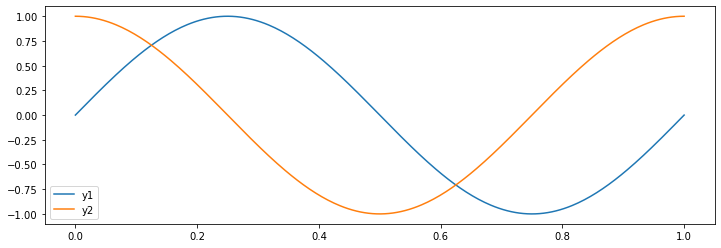

In [19]:
fig, ax = pl.subplots(figsize=(12, 4))
ax.plot(t, result[0][0, :], label='y1')
ax.plot(t, result[0][1, :], label='y2')
ax.legend(loc='best');

As expected, this gives me my sine and cosine as defined within my function.  Now, let's look at the second element of my results varible which will be the "tangents."  Since I am supplying input differentials of 1 or 0, the output "tangents" should just be the time derivatives of my inputs.  Let's verify that.

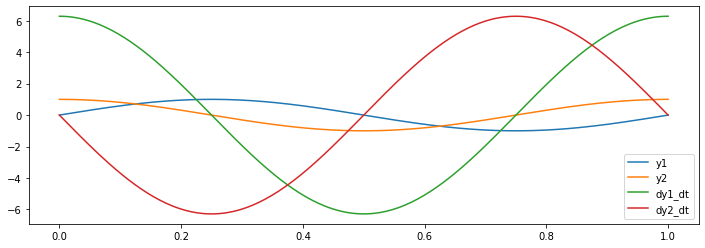

In [20]:
fig, ax = pl.subplots(figsize=(12, 4))

# Plot my function as above
ax.plot(t, result[0][0, :], label='y1')
ax.plot(t, result[0][1, :], label='y2')

# Now also plot the derivatives
ax.plot(t, result[1][0, :], label='dy1_dt')
ax.plot(t, result[1][1, :], label='dy2_dt')


ax.legend(loc='best');

As expected, this is giving the appropriate derivatives.  For example $\frac{dy_1}{dt}=a\omega\cos(\omega t)$

Now let's do something a little different.  Let's ask the question.  What does $\frac{dy_1}{dw}$ look like as a function of time?  Well, now, when I supply the input differentials to the `jvp` function, I don't care about time or amplitude.  I just care about frequency.  So I will zero out everything except frequency, like this.

In [21]:
# These just copied from above
t = jnp.linspace(0, 1, 300)
a = 1
w = 2 * jnp.pi * 5  
params = jnp.array([a, w])


result = jax.jvp(
    func,                         # fun
    (t, params),                  # primals
    (
        jnp.zeros_like(t),       # Zero out time tangents.  Don't care
        jnp.array([0., 1.])      # Zero out amplitude tangent, but set frequency tangent to 1
    )             
)

Now let's plot our results again using basically the same code as above.

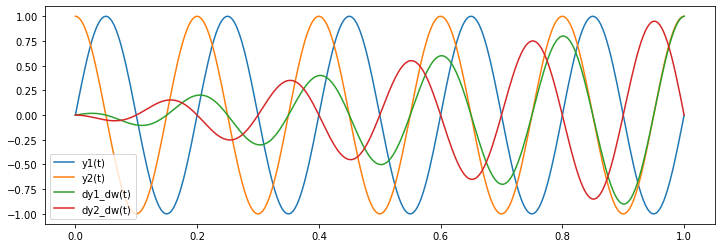

In [22]:
fig, ax = pl.subplots(figsize=(12, 4))

# Plot my function as above
ax.plot(t, result[0][0, :], label='y1(t)')
ax.plot(t, result[0][1, :], label='y2(t)')

# Now also plot the derivatives
ax.plot(t, result[1][0, :], label='dy1_dw(t)')
ax.plot(t, result[1][1, :], label='dy2_dw(t)')


ax.legend(loc='best');

Now, for this example, I increased the frequency a bit to make it more obvious that we have the expected $\frac{dy_1(t)}{d\omega} = a t \cos(\omega t)$.